In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image

# Data

generate plots with corresponding masks

In [187]:
class PlotDataset(Dataset):
    def __init__(self, num_samples, transform=None, tolerance=5):
        self.num_samples = num_samples
        self.transform = transform
        self.tolerance = tolerance

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random coefficients
        a1, a2 = np.random.uniform(-10, 10, 2)
        a3, a4, a5 = np.random.uniform(-1, 1, 3)
        
        # Generate x values
        x = np.linspace(-10, 10, 100)
        
        # Generate y values for linear and parabolic functions
        y_linear = a1 * x + a2
        y_parabolic = a3 * x**2 + a4 * x + a5
        
        # Create figure
        fig, ax = plt.subplots()
        ax.set_xlim(-10, 10)
        ax.set_ylim(-100, 100)
        
        # Plot the linear function
        line_color = np.random.rand(3,)
        ax.plot(x, y_linear, color=line_color)
        
        # Plot the parabolic function
        parab_color = np.random.rand(3,)
        ax.plot(x, y_parabolic, color=parab_color)
        
        # Save plot as image
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)
        
        # Convert RGBA to RGB
        image = image[:, :, :3]
        
        # Create mask
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Draw axes on mask (Assuming axes are black lines)
        mask[image[:, :, 0] == 0] = 1
        
        # Define a helper function for color matching with tolerance
        def within_tolerance(img, color, tol):
            return np.all(np.abs(img - np.array(color) * 255) <= tol, axis=-1)
        
        # Add linear function to mask
        mask[within_tolerance(image, line_color, self.tolerance)] = 2
        
        # Add parabolic function to mask
        mask[within_tolerance(image, parab_color, self.tolerance)] = 3
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        
        # Convert mask to tensor manually to avoid scaling
        mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

# Define transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = PlotDataset(num_samples=1000, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

torch.Size([32, 3, 480, 640]) torch.Size([32, 480, 640])


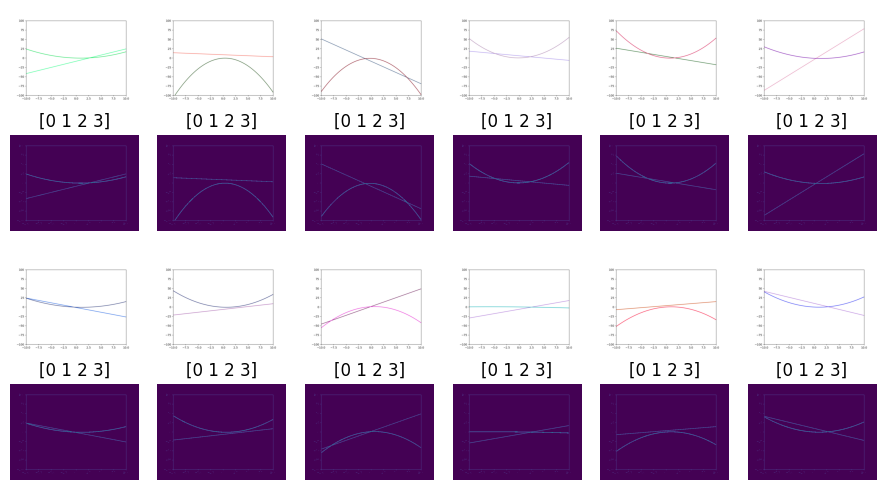

In [209]:
# Example usage
for images, masks in dataloader:
    print(images.shape, masks.shape)
    break

fig, axes = plt.subplots(4, 6, figsize=(9, 5))
axes = axes.ravel()

for i in range(6):
    axes[i].imshow(images[i].permute(1,2,0))
    axes[i].axis("off")
    axes[i+6].imshow(masks[i])
    axes[i+6].axis("off")
    axes[i + 6].set_title(f"{np.unique(masks[i])}")

for i in range(6):
    axes[i + 12].imshow(images[i + 6].permute(1,2,0))
    axes[i + 12].axis("off")
    axes[i + 18].imshow(masks[i + 6])
    axes[i + 18].axis("off")
    axes[i + 18].set_title(f"{np.unique(masks[i + 6])}")

plt.tight_layout()
plt.show()

In [193]:
from torch import nn

class TestDense(nn.Module):

    def __init__(self, **kwargs):
        super(TestDense, self).__init__(**kwargs)
        self.layer1 = nn.Linear(1, 10)
        self.layer2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
    
test_model = TestDense()
print(test_model)


TestDense(
  (layer1): Linear(in_features=1, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)


In [223]:
from torch.functional import F
from torch import nn
from torchinfo import summary

CONV_KERNEL = (3, 3)
POOL_KERNEL = (2, 2)
STRIDE_SIZE = (1, 1)
PADDING_TYPE = 1

class DownBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels, **kwargs):
        super(DownBlock, self).__init__(**kwargs)

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.conv_2 = nn.Conv2d(in_channels=out_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.batch_1 = nn.BatchNorm2d(num_features=out_channels)
        self.batch_2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=POOL_KERNEL)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

def UpperBlockCustom(ConvTranspose, in_channels, out_channels):
    class UpperBlock(nn.Module):
        def __init__(self, in_channels: int, out_channels: int, **kwargs):
            super(UpperBlock, self).__init__(**kwargs)
            self.convT = ConvTranspose(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=CONV_KERNEL,
                                       stride=STRIDE_SIZE,
                                       padding=PADDING_TYPE)

        def forward(self, x, w=None):
            if w is not None:
                x = self.convT(x, w)
            else:
                x = self.convT(x)
            s = x.shape[2:]
            x = F.interpolate(x,
                              size=(s[0] * 2, s[1] * 2),
                              mode='bilinear',
                              align_corners=False)
            return x

    return UpperBlock(in_channels, out_channels)

n = 6
class UNet(nn.Module):

    def __init__(self, depth: int = 3, **kwargs):
        super(UNet, self).__init__(**kwargs)
        self.depth = depth
        self.down_blocks = nn.ModuleDict()
        self.down_blocks[str(0)] = DownBlock(in_channels=1,
                                        out_channels=64)
        n_feat = 64
        for i in range(1, depth):
            self.down_blocks[str(i)] = DownBlock(in_channels=n_feat,
                                            out_channels=2 * n_feat)
            n_feat *= 2

        self.up_block = nn.ModuleDict()
        self.up_block[str(0)] = UpperBlockCustom(nn.ConvTranspose2d,
                                            64, 1)
        n_feat = 64 * (2 ** (depth - 1)) // 2
        for i in range(1, depth):
            self.up_block[str(depth-i)] = UpperBlockCustom(nn.ConvTranspose2d,
                                                  2 * n_feat, n_feat)
            n_feat //= 2

    def forward(self, x):
        x = self.down_blocks[str(0)](x)
        for i in range(1, self.depth):
            x = self.down_blocks[str(i)](x)
        for i in range(1, self.depth):
            x = self.up_block[str(self.depth - i)](x)
        x = self.up_block[str(0)](x)
        return x

model = UNet(depth=3)
summary(model, input_size=(1, 1, 128, 128))

torch.Size([1, 1, 128, 128])

ModuleDict(
  (0): DownBlock(
    (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (1): DownBlock(
    (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
)


In [221]:
print(model.up_block)

ModuleDict(
  (0): UpperBlock(
    (convT): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (5): UpperBlock(
    (convT): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
